In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Mask-RCNN-TF2

/content/drive/MyDrive/Mask-RCNN-TF2


In [8]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

Cloning into 'Mask-RCNN-TF2'...
remote: Enumerating objects: 1434, done.
remote: Total 1434 (delta 0), reused 0 (delta 0), pack-reused 1434
Receiving objects: 100% (1434/1434), 144.53 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (419/419), done.


In [10]:
!pip install -r requirements.txt

     |████████████████████████████████| 516.2 MB 4.2 kB/s 
     |████████████████████████████████| 377 kB 52.6 MB/s 
     |████████████████████████████████| 2.9 MB 36.7 MB/s 
     |████████████████████████████████| 3.0 MB 22.4 MB/s 
     |████████████████████████████████| 454 kB 74.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Fo

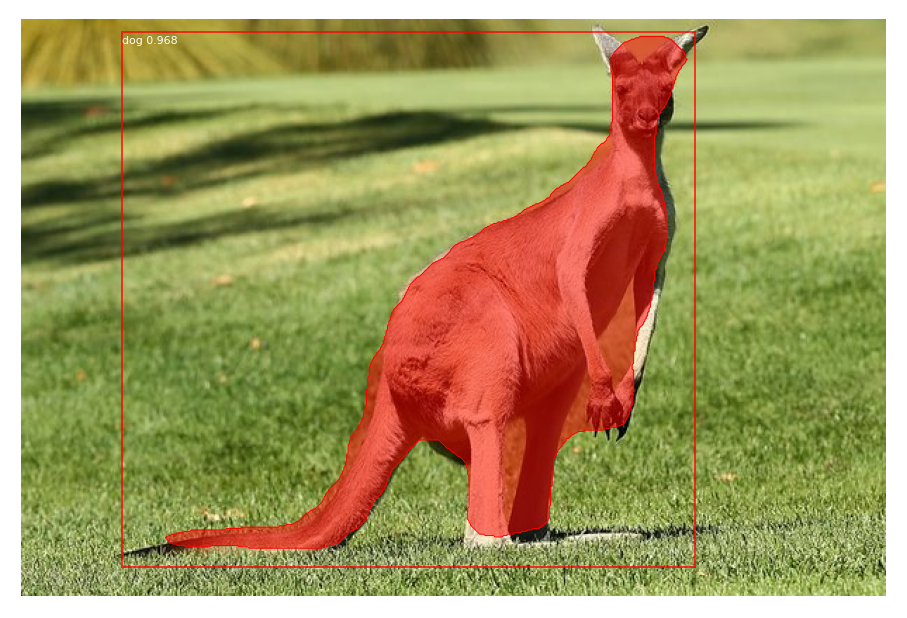

In [5]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

# load the class label names from disk, one label per line
# CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")

CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
# Download the mask_rcnn_coco.h5 file from this link: https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
model.load_weights(filepath="mask_rcnn_coco.h5", 
                   by_name=True)

# load the input image, convert it from BGR to RGB channel
image = cv2.imread("00017.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

In [3]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Mask-RCNN-TF2/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + (Horse and Man)
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

Using TensorFlow backend.


In [4]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "Horse")
        self.add_class("object", 2, "Man")
        # self.add_class("object", 3, "xyz") #likewise

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"Horse": 1,"Man": 2} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [5]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/drive/MyDrive/Mask-RCNN-TF2/dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/drive/MyDrive/Mask-RCNN-TF2/dataset", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model)

objects: ['Man', 'Horse', 'Man', 'Horse', 'Man']
numids [2, 1, 2, 1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man', 'Man']
numids [1, 2, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Horse', 'Man']
numids [1, 2]
objects: ['Man', 'Horse', 'Horse', 'Man']
numids [2, 1, 1, 2]
objects: ['Man', 'Horse', 'Man', 'Man', 'Man', 'Horse', 'Horse', 'Horse']
numids [2, 1, 2, 2, 2, 1, 1, 1]
Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 5/10 [==============>...............] - ETA: 20:14 - loss: 3.3709